### Seminar 1:
# Genetic Programming for Symbolic Regression
Intelligent Systems

## Overview 
Goal: We have a dataset, which holds y values for x values as input. By using a genetic algorithm our goal is to find equations which produced the y values - so we do symbolic regression.  

The overall structure for our appoach is:
1) We read in the dataset and split it according to a choosen index into x values, y values and the real equation.  
2) We decided to represend an individual (= an equation) in form of a list of integars, which must be read in pre-order-traversal (so we have pre-order trees). We chose this traversal because otherwise it was difficult to create random equations for the initial population. The integars of the individuals represent the genes and are mapped via a dictionary to operators, operands and the ending point of an equation. To make sure that every population member has the same number of genes we filled up our indivdiuals of the initial population with the number 16, which represents END.
3) Our fitness function evaluates two aspects of an individual: Its complexity (length, task 3) and the MQE. The fitness is their weighted sum (f = -(alpha * MSE + beta * complexity)) and can be adopted by changing the parameters alpha and beta to set the focus on eighter equations which compute the right result or on shorter equations. To avoid overflow errors we scale or equations and the input x-values by the factor 0.01.
4) Our mutation function muatates genes according to their function. So an operand stays as an operands and and operator stays as an operator.
5) Our crossover funcitons are two versions. First function is single point crossover and the other one is two point crossover.




In [542]:
# import and load data
from sympy import *
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib
import numpy as np
import ast
import pygad
import random
import copy
import warnings
import sympy

dat = pd.read_csv("dataset.csv", sep=",")  # data in dataframe .
dat.head(15)

,Equation,Xs,Ys
0,((x ** 4) - 6),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-5, 10, 75, 250, 619, 1290, 2395, 4090, 6555,..."
1,(((x / 8) * 2) + 1),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3..."
2,(((x - 1) - 3) / 5),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1...."
3,(x * 5),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
4,(x + 2),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
5,((x + 1) * 7),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 9..."
6,((x + 2) ** 9),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[19683, 262144, 1953125, 10077696, 40353607, 1..."
7,(x * 2),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 2..."
8,(((x ** 8) * 5) / 3),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.6666666666666667, 426.6666666666667, 10935...."
9,(x / 7),"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.14285714285714285, 0.2857142857142857, 0.42..."


### Data set

In [543]:
"""
acoording to a specific row index it splits pandas-dataframe into equation, x-vals and y-vals 

@param dataframe: dataframe we want to split
@param index (int): index of the specific row 

@return x, y, equ (list, list, list): = str(x-vals), str(y-vals), str(equation)
"""

def build_2D_dataset(dataframe, index):
    equ = dat["Equation"][index]
    x = ast.literal_eval(dat["Xs"][index])
    y = ast.literal_eval(dat["Ys"][index])
    return x, y, equ

# get value
INDEX = 0 # change here to see how the algoritm works for different equations

dat_index = build_2D_dataset(dat, INDEX)
x_of_specfic_index = dat_index[0]
y_of_specfic_index = dat_index[1]
equation = dat_index[2]

### Representation of equations and initialization of population

We want to represent equations in form of trees, which will be in pre-order-traversal. 
Because genes of individuals in the populations must be of type int, we need to translate operands and operators into ints.

In [544]:
# represet genes
operands_dict = {
    "x":10,
    "-":11,
    "/": 12,
    "*":13,
    "+":14,
    "**": 15,
    "END": 16,
}

for i in range(10):
    operands_dict[str(i)] = i

We create an initial population randomly.
An individual is an equaiton, stored as a pre-order-tree (list).

In [545]:
operators = [11, 12, 13, 14]
variables = [10]
MAX_DEPTH = 3

"""
creates random indiviudals, the maximal exponent is fix to avoid overflow in calculation later (e.g. x ** x)

@param max_exponent (int): maximal exponent we will have in our equations
@param depth (int): current depth (start at 0)
@param max_depth (int): maximal depth of the tree 

@return: nested list which must be read pre-order-wise
"""
def create_individuum(max_exponent, max_depth, depth = 0):
    if depth == max_depth or (random.random() < 0.7 and depth ==1):
        if random.random() < 0.5:
            return random.choice(variables)
        else:
            return (random.randint(1, 10))
    # choose operator randomly
    operator = random.choice(operators)
    if random.random() < 0.3:
        left_subtree = [15, 10, max_exponent]
    else:
        if max_exponent <= 2:
            left_subtree = create_individuum(2, max_depth, depth + 1)
        else: 
            left_subtree = create_individuum(random.randint(2, max_exponent),max_depth, depth + 1)
    # create subtree randomly
    if max_exponent <= 2:
        right_subtree = create_individuum(2 ,max_depth, depth + 1)
    else:
        right_subtree = create_individuum(random.randint(2, max_exponent),max_depth, depth + 1)
    
    # return tree
    return [operator, left_subtree, right_subtree]

"""
flattens a nested list, needed to translate the pre-order-trees into in-order-trees later

@param nested_list (list): individual in form of a nested list

@return flattened_list (list): individual in form of a flattend list 
"""
def flatten_list(nested_list):
    if isinstance(nested_list, int):
        return [nested_list]
    else: 
        flattened_list = []
        for element in nested_list:
            if isinstance(element, list):
                flattened_list.extend(flatten_list(element))
            else:
                flattened_list.append(element)
        return flattened_list

# example
RANDOM_TREE_1 = create_individuum(4, MAX_DEPTH)
print(RANDOM_TREE_1)

RANDOM_TREE_1_FLAT = flatten_list(RANDOM_TREE_1)
print(RANDOM_TREE_1_FLAT)
#print(pre_order_to_equation(translate(RANDOM_TREE_1_FLAT)))


[12, [15, 10, 4], 10]
[12, 15, 10, 4, 10]


We now can inititalize a whole population with randomly build individuals. Because every individual needs the same number of genes, we fill each individual up with 16 (= END of equation)

In [546]:
POPULATION_SIZE = 20
NUM_OF_GENES = 50

"""
initializes a population with indiviuals of same number of genes

@param population_size (int): number of indiviudals in a populaiton
@param max_depth (int): maximal depth of the tree
@param desired_num_of_genes (int): number of genes of an individuum

@return population (list of lists): individuals in population
"""
def initialize_population(population_size, max_depth, desired_num_of_genes):
    population = []
    for _ in range(population_size):
        #depth = random.randint(1, max_depth) # adjust maybe the depth?
        random_exponent = random.randint(1, 10)
        individual = create_individuum(random_exponent, max_depth)
        individual = flatten_list(individual)
        for i in range(1, len(individual) - 1):
            if (individual[i - 1] == 15 and individual[i + 1] == 10): # sort out exponential equations (10 : "x")
                individual[i + 1] = 2 # we want to avoid x ** x and change such indiviudals
            if (individual[i] == individual[i + 1]): # avoid equations like x + x, 2 * 2
                if individual[i] == 10:
                    individual[i + 1] = random.randint(1, 10)
                else:
                    individual[i + 1] = 10 
        
        if len(individual) < desired_num_of_genes:
            individual += [16] * (desired_num_of_genes - len(individual))
        population.append(individual)
    
    return population


EXAMPLE_POPULATION = initialize_population(POPULATION_SIZE, MAX_DEPTH, NUM_OF_GENES) 
print(EXAMPLE_POPULATION)
#for i in EXAMPLE_POPULATION:
#    print(pre_order_to_equation(translate(i)))

[[12, 10, 11, 14, 15, 10, 2, 10, 12, 15, 10, 2, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], [11, 5, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], [14, 6, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], [14, 5, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], [11, 14, 11, 10, 6, 11, 10, 1, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1

Which help of the upper dictionary we translate our indiviudals into lists of strings so that we can evaluate them later.

In [547]:
"""
translates an pre-order list of ints = individual into a pre-order list of strings via the defined operands dictionary

@param inidvidual (list): list of ints in pre-order

@return equation (list): list of strings (the translated ints)
"""
def translate(inidvidual):
    equation = []
    for j in range(len(inidvidual)):
        if inidvidual[j] == 16:
            break # we found end of equation
        if isinstance(inidvidual[j], int) or isinstance(inidvidual[j], np.int64):
            for key, value in operands_dict.items():
                if value == inidvidual[j]:
                    equation.append(key)
                    break
        else:
            for i in range(len(inidvidual[j])):
                for key, value in operands_dict.items():
                    if value == inidvidual[j][i]:
                        equation.append(key)
                        break   
    return equation


# examples
EXAMPLE_1 = [14, 1, 10]
TRANSLATED_EXAMPLE_1 = translate(EXAMPLE_1)
print(TRANSLATED_EXAMPLE_1)

EXAMPLE_2 = [11, 12, 10, 10, 15, 10, 3]   
TRANSLATED_EXAMPLE_2 = translate(EXAMPLE_2)
print(TRANSLATED_EXAMPLE_2)


['+', '1', 'x']
['-', '/', 'x', 'x', '**', 'x', '3']


We order our pre-order list of stings into in-order so that we can afterwards evaluate the string list easily.

In [548]:
"""
orders a pre-order list of strings (= individual) into a in-order list of strings 

@param inidvidual (list): list of strings in pre-order

@return equation (list): list of strings in in-order
"""
def pre_order_to_equation(inidvidual):
    stack = []
    index = [0]  # track current index

    def helper():
        if index[0] >= len(inidvidual):
            return None

        current = inidvidual[index[0]]
        index[0] += 1

        if current.isdigit() or current.isalpha():
            return current

        left = helper()
        operator = current
        right = helper()

        # set brakes if we have left and right 
        if left and right:
            return f"({left} {operator} {right})"
        else:
            return f"{left} {operator} {right}"

    equation = helper()
    return equation


# examples
# TRANSLATED_EXAMPLE_1 = ['**', '1', 'x']
EQUATION_TRANSLATED_EXAMPLE_1 = pre_order_to_equation(TRANSLATED_EXAMPLE_1)
print(EQUATION_TRANSLATED_EXAMPLE_1)

# TRANSLATED_EXAMPLE_2 = ['-', '/', 'x', 'x', '+', 'x', '3']
EQUATION_TRANSLATED_EXAMPLE_2 = pre_order_to_equation(TRANSLATED_EXAMPLE_2)
print(EQUATION_TRANSLATED_EXAMPLE_2)

(1 + x)
((x / x) - (x ** 3))


Now we can easily evaluate the equations with a given x as input. We also scale our individuals by the factor 0.01 here! Invalid equations we filter out here (e.g. division by zero).

In [549]:
"""
evaluates a list of strings (equation) and catches errors if the equation is invalid
@param inidvidual (list): list of strings in pre-order

@return equation (float or None): result of the evaluated expression
"""
def evaluate_expression(individual, x_value):
    x = x_value
    equation = pre_order_to_equation(individual)
    equation = str(equation) + " * 0.01" # scaling
    #print("equation: ", equation,  "    x: ", x)
    # sort out equations with  x ** x 
    try: 
        #with warnings.catch_warnings():
            #warnings.filterwarnings("ignore", category=RuntimeWarning)  # Filtert die RuntimeWarnings
            #res = eval(equation)
        #print("try ", equation, "    ", x)
        res = eval( equation)
    except: 
        res = None 
    return res

# examples
RES_2 = evaluate_expression(TRANSLATED_EXAMPLE_2, 4)
print(RES_2)

INVALID_EXAMPLE = evaluate_expression(["x", "END", "END"], 0) # so it catches also division by 0 / invalid equaitons
print(INVALID_EXAMPLE)

-0.63
0.0


### Fitness function
We need to evaluate each individuum of the current population with a fitness function.
For this we translate our indiviual, which is in form of a list(ints) (e.g. [11, 3, 10]) into a list of strings in preorder and then in in-order (e.g. ["3", "+", "x"]) and evaluate it.
We then calculate the the mean squared error (MSE) for the given indiviudal to measure how close to the real equaiton it is. Because we scaled our individuals, we compare their result to the also scaled real y values. Besides, we determine its complexity (lenght) and define the fitness as a weighted sum of these two values.

In [550]:
START_IDX = 10 # choose how many values of the dataset we take to determine the fitness
STOP_IDX = 100

"""
determines the fitness of an individual as the weighted sum of its MSE and complexitiy
@param ga_instance (object): instance of the pygad.GA class
@param solution: current solution
@param solution_idx (int): index of solution 

@return fitness (float): fitness value of individal / solution
"""
def fitness_function(ga_instance, solution, solution_idx): 
    
    error_value = -math.inf # if a equaiton is invalid we set the fitness very low, which will sort them out by the algorithm
    
    # scale down to avoid overflow
    x_vals = np.array(x_of_specfic_index)[START_IDX:STOP_IDX] 
    
    # real y values
    y_scaled = np.array(y_of_specfic_index[START_IDX:STOP_IDX]) * 0.01

    # computed y values
    y_model = []
    equation = translate(solution)
    
    for x in x_vals:
        evaluated_equation = evaluate_expression(equation, x)
        if evaluated_equation == None: # invalid expression --> set fitness extreme low
            return error_value
        elif isinstance(evaluated_equation, complex):
            return error_value # complex number found --> invalid for us
        elif evaluated_equation == math.inf:
            return error_value # happens when e.g. (7 / (0 * x))
        # print("evaluated_equation" , evaluated_equation)
        y_model.append(evaluated_equation)
    
    try:       
        MSE = np.sum((y_scaled- y_model) ** 2) / x_vals.shape[0]
    
    except RuntimeWarning:
        return error_value
    
    alpha = 0.9 # adjust to make another weighted sum
    beta = 0.1
    #print(equation)
    complexity = len(equation) 
    #print("complexity: ", complexity)
    #print("MQE: ", MQE)
    fitness = -(alpha * MSE + beta * complexity) # minus because we want to find the individuals with maximal fitness
    return fitness

#fitness_function([[12, 1, 10], [12, 1, 10]], [13, 5, 10], 0)

Comparison for different values for alpha and beta in the fitness funtion:  

When we want to set the focus on finding the correct equation, no matter how long is we set beta = 0. For a correct equation the fitness will be then zero. But this can leed to finding results, which are not maximally simplified. E.g. the equation f(x) = ((x ** 1) + 9) would be evaluated with a fitness of zero, but it could be simplified to f´(x) = (x + 9).  
When we want to focus more on shorter equaitons we set beta higher. But this has an influence on the correctness of the equation.

In [551]:
# let this be a not simplified equaiton: f(x) = ((x ** 1) + 9) --> in translated pre-order:
f = [14, 15, 10, 1, 9]
f_equation = pre_order_to_equation(translate(f))
print(f_equation)

f_fitness_beta_0 = fitness_function([[12, 1, 10], [12, 1, 10]], f, 0) # set beta = 0 in fitness funciton
print("fitness with beta = 0 :", f_fitness_beta_0)

((x ** 1) + 9)
fitness with beta = 0 : -116177368019.14679


In [552]:
f_fitness_beta_02 = fitness_function([[12, 1, 10], [12, 1, 10]], f, 0) # set beta = 0.2 in fitness funciton
print("fitness with beta = 0 :", f_fitness_beta_02)

fitness with beta = 0 : -116177368019.14679


### Mutation
To change our indiviudals we mutate some of them by replacing a operator / operand which a randomly drawn operator / operand.
The second function cutts

In [553]:
"""
@param offspring: Among these offspring, one to undergo mutation is selected.

@return mutated_solution: return offspring with mutation

"""
def custom_mutation(offspring, ga_instance):
    # Choose a random index to mutate
    mutated_solution = offspring
    random_gene = random.randint(0, len(offspring) - 1)
    gene = offspring[random_gene]

    limit = len(gene)
    for i in range(limit):
        if gene[i] == 16:
            limit = i
            break

    random_idx = random.randint(0,limit-1)

    # mutate the selected gene
    if gene[random_idx] >= 1 and gene[random_idx] <= 10:
        # mutate genes in the range [1, 10]
        mutated_gene = random.randint(1, 10)
    elif gene[random_idx] >= 11 and gene[random_idx] <= 15:
        # mutate genes in the range [11, 15]
        mutated_gene = random.randint(11, 15)

    mutated_solution[random_gene][random_idx] = mutated_gene

    return mutated_solution

# another idea for a mutation is to cut off some parts of an equation by multiplying a part of the equation with zero
def custom_mutation_2(offspring, ga_instance):
    # Choose a random index to mutate
    mutated_solution = offspring
    random_gene = random.randint(0, len(offspring) - 1)
    gene = offspring[random_gene]

    limit = len(gene)
    for i in range(limit):
        if gene[i] == 16:
            limit = i
            break

    random_idx = random.randint(0,limit-1)

    # Mutate the selected gene
    if gene[random_idx] >= 1 and gene[random_idx] <= 10:
        # Mutate genes in the range [1, 10]
        mutated_gene = random.randint(1, 10)

    elif random.random() < 0.8 and gene[random_idx] == 13 and gene[random_idx + 1] >= 1 and gene[random_idx +1] <= 10:
        # cut off some parts by multiplication by 0
        mutated_gene = 13
        mutated_solution[random_gene][random_idx + 1] = 0

    elif gene[random_idx] >= 11 and gene[random_idx] <= 15:
        # Mutate genes in the range [11, 15]
        mutated_gene = random.randint(11, 15)
    
    else:
        mutated_gene = gene[random_idx]

    mutated_solution[random_gene][random_idx] = mutated_gene

    return mutated_solution

# example: comment out like this to make it run: def custom_mutation_2(offspring): #, ga_instance):
"""offspring = [
    [2, 13, 7, 13, 10, 13, 16, 9, 11],
    [5, 15, 12, 16, 8, 4, 3, 2, 1]
]
mutated_offspring = custom_mutation_2(offspring)
print("Mutated Offspring:")
for i, gene in enumerate(mutated_offspring):
    print(f"Gene {i + 1}: {gene}")
"""

'offspring = [\n    [2, 13, 7, 13, 10, 13, 16, 9, 11],\n    [5, 15, 12, 16, 8, 4, 3, 2, 1]\n]\nmutated_offspring = custom_mutation_2(offspring)\nprint("Mutated Offspring:")\nfor i, gene in enumerate(mutated_offspring):\n    print(f"Gene {i + 1}: {gene}")\n'

### Crossover


In [554]:
"""
@param offspring size(tuple): (the offspring size, number of genes) 
@param parents(list): selected parents

@return np.array(offspring): result offsprings of the crossover

@singlepoint: using a single crossover point for the crossover operation among parents
@twopoint: using two crossover points for the crossover operation among parents
"""
def crossover_singlepoint(parents, offspring_size,ga_instance):
    offspring = []
    idx = 0
    parents = np.array(parents)
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()

        #consider 16
        limit = offspring_size[1]
        for i in range(offspring_size[1]):
            if parent1[i] == 16:
                limit = i
                break

        # Choose one random split points
        random_split_point = np.random.choice(range(limit))  

        # Perform one-point crossover
        os = np.concatenate((parent1[:random_split_point], parent2[random_split_point:]))

        # except when the equation is not valid
        if evaluate_expression(translate(os),1) != None:
            offspring.append(os)
            idx += 1

    return np.array(offspring)

###########
INITIAL_POPULATION_ex = initialize_population(50, 3, 30) 
def crossover_singlepoint_ex(parents, offspring_size):
    offspring = []
    idx = 0
    parents = np.array(parents)
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()

        #consider 16
        limit = offspring_size[1]
        for i in range(offspring_size[1]):
            if parent1[i] == 16:
                limit = i
                break

        # Choose one random split points
        random_split_point = np.random.choice(range(limit))  

        # Perform one-point crossover
        os = np.concatenate((parent1[:random_split_point], parent2[random_split_point:]))

        # except when the equation is not valid
        if evaluate_expression(translate(os),1) != None:
            offspring.append(os)
            idx += 1

    return np.array(offspring)

### example
#example_of_crossover = crossover_singlepoint_ex(INITIAL_POPULATION_ex,(50,30))
#for a in example_of_crossover:
#    example_of_crossover_value = evaluate_expression(translate(a), 4)
#    print(a)
#    print(example_of_crossover_value)


def crossover_twopoint(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0

    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()

        limit = offspring_size[1]
        for i in range(offspring_size[1]):
            if parent1[i] == 16:
                limit = i
                break

        # Choose two random split points
        split_points = np.sort(np.random.choice(range(limit), size=2, replace=True))

        # Perform two-point crossover
        os = copy.deepcopy(parent1)

        os[split_points[0]:split_points[1]] = parent2[split_points[0]:split_points[1]]

        # except when the equation is not valid
        if evaluate_expression(translate(os),1) != None:
            offspring.append(os)
            idx += 1

    return np.array(offspring)



In [555]:
"""
determines gene space for each gene, it is the same for each individual of the population
@param population (list): list of individauls

@return gene_space (list): list (in lenght of the number of genes) of dictionaries which store the range of the genen
"""
def determine_gene_space(population):
    gene_space = []
    for indiviuduals in range(len(population[0])): # determine boarders for every gene
        gene_space.append({'low': 0, 'high': 16})
    return gene_space

Initialize the populaiton, set the values for the parameters and run the algorithm.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.01
crossover probability:  0.1

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 6)
Fitness -0.5
Index 0



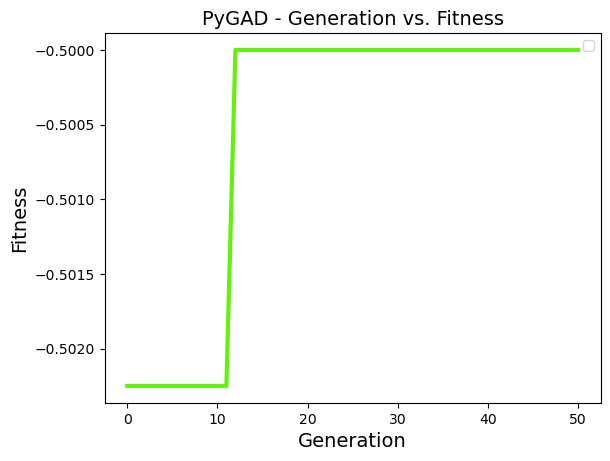

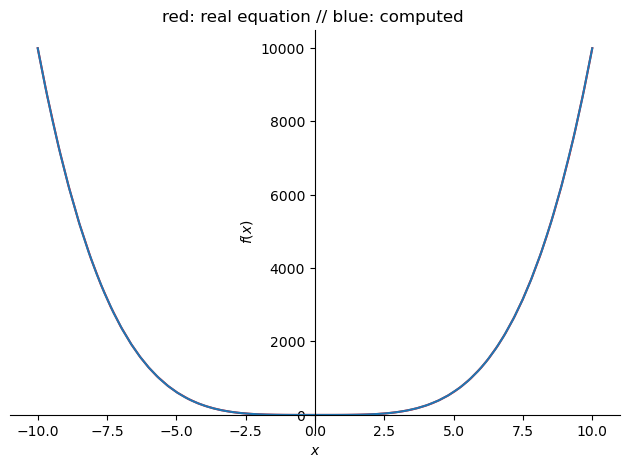

<string>:1: RuntimeWarning: overflow encountered in long_scalars
<string>:1: RuntimeWarning: overflow encountered in double_scalars
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.01
crossover probability:  0.45

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 6)
Fitness -0.5
Index 0



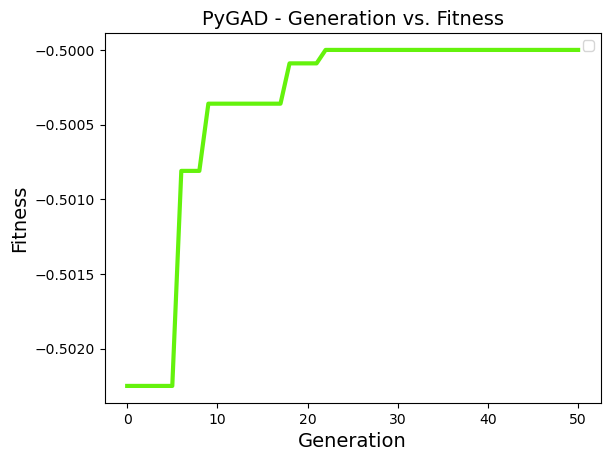

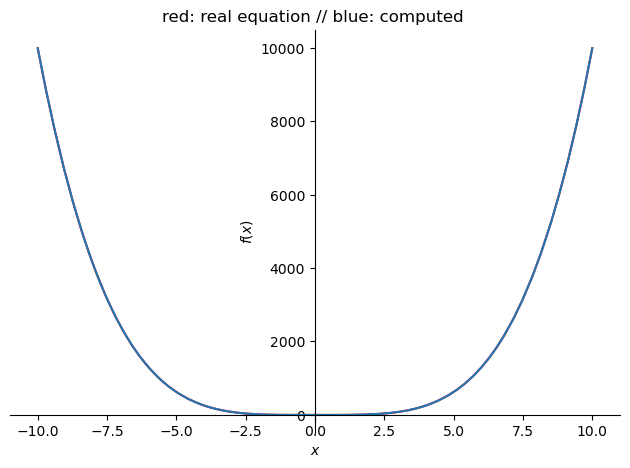

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.01
crossover probability:  0.8

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 5)
Fitness -0.5000899999999789
Index 0



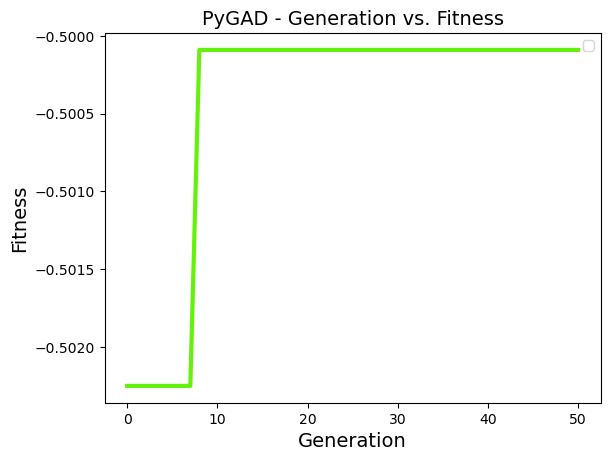

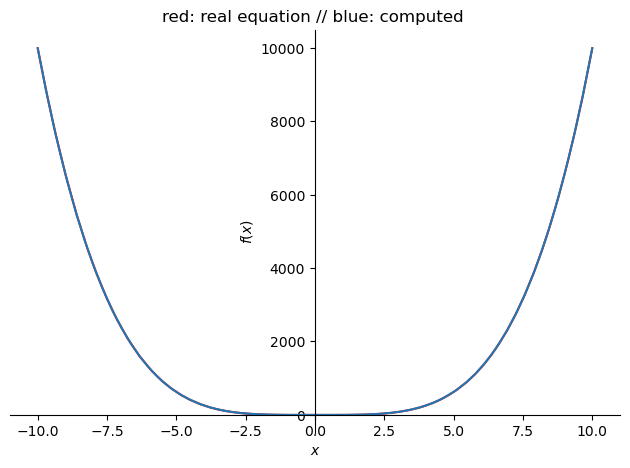

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.05
crossover probability:  0.1

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 5)
Fitness -0.5000899999999789
Index 0



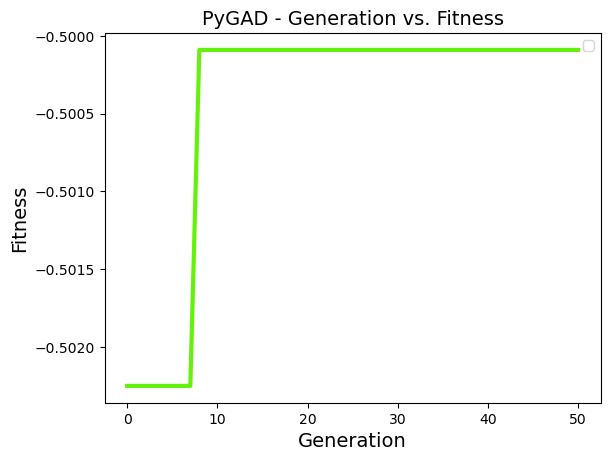

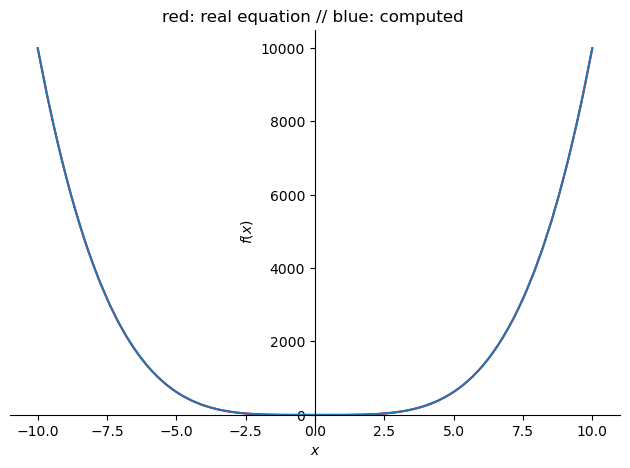

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.05
crossover probability:  0.45

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 6)
Fitness -0.5
Index 0



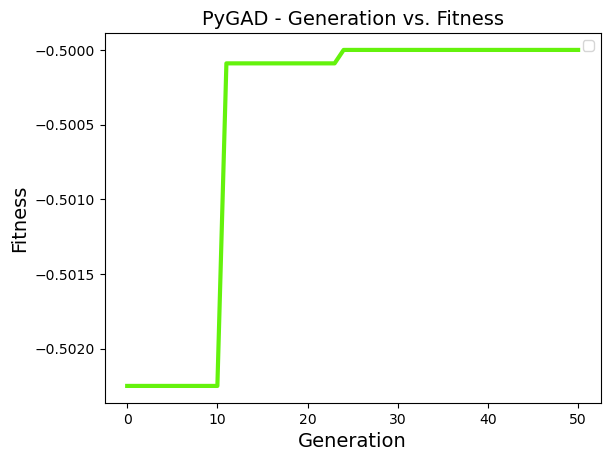

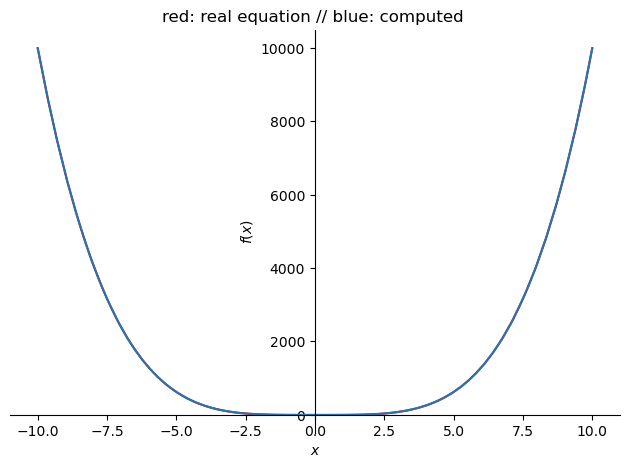

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.05
crossover probability:  0.8

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 6)
Fitness -0.5
Index 0



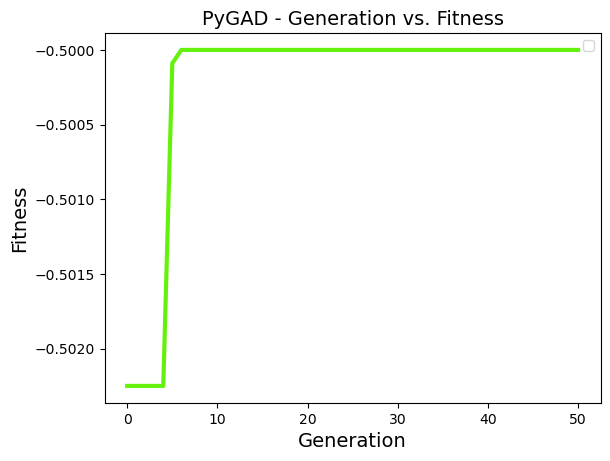

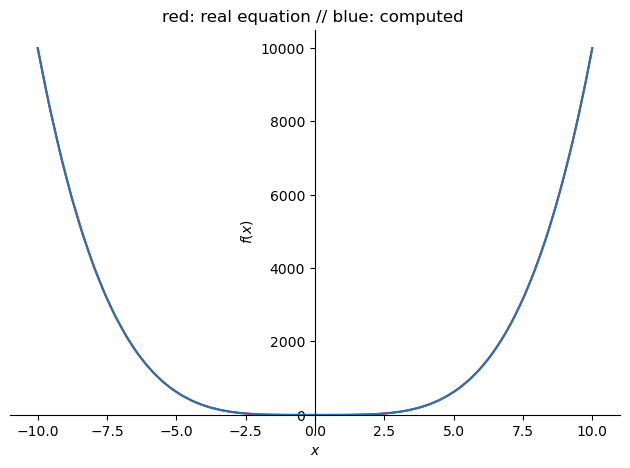

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.1
crossover probability:  0.1

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 5)
Fitness -0.5000899999999789
Index 0



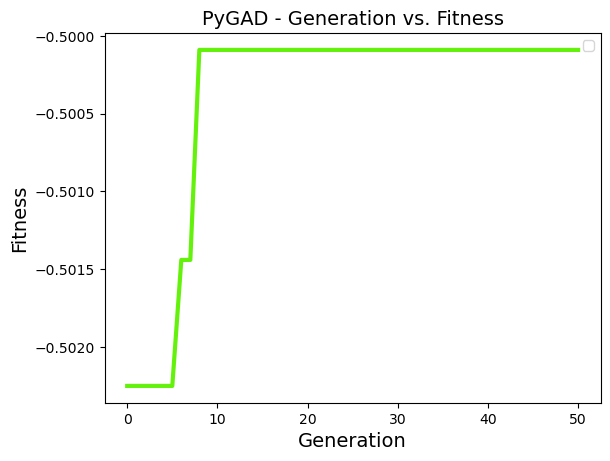

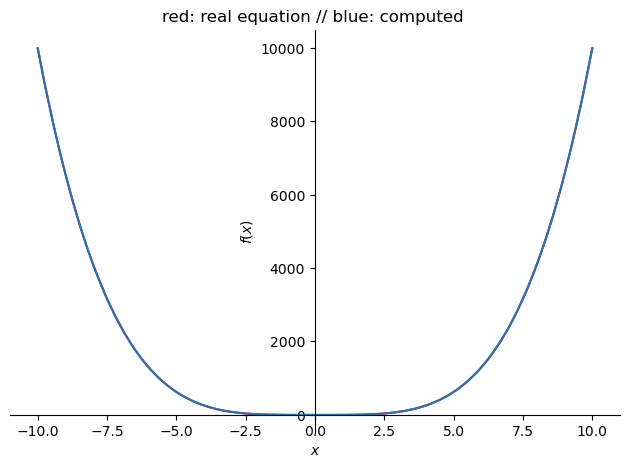

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.1
crossover probability:  0.45

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 6)
Fitness -0.5
Index 0



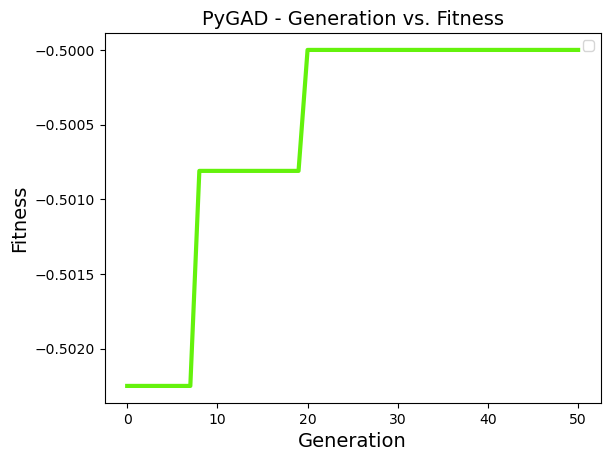

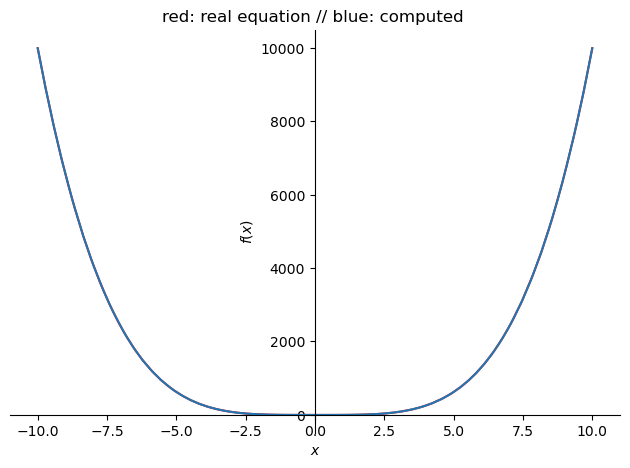

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.1
crossover probability:  0.8

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 7)
Fitness -0.5000900000000441
Index 0



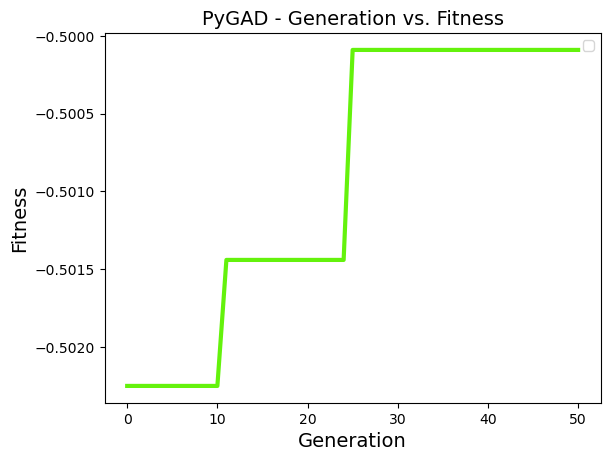

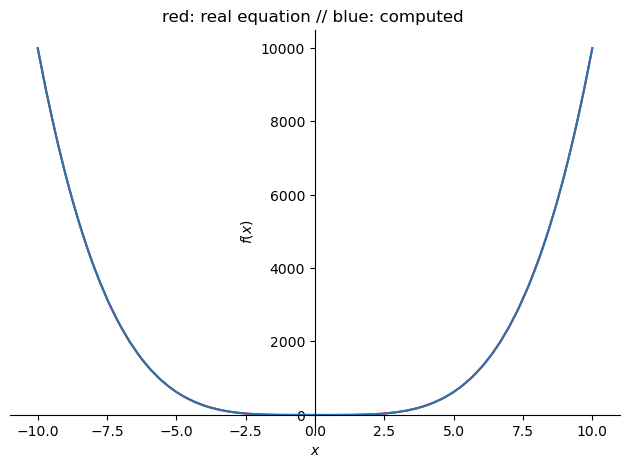

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.5
crossover probability:  0.1

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 6)
Fitness -0.5
Index 0



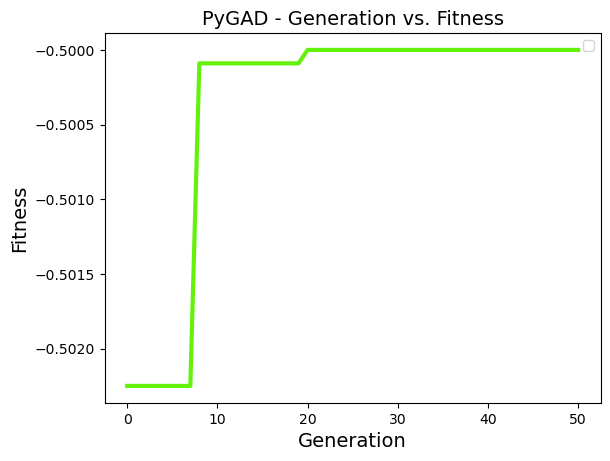

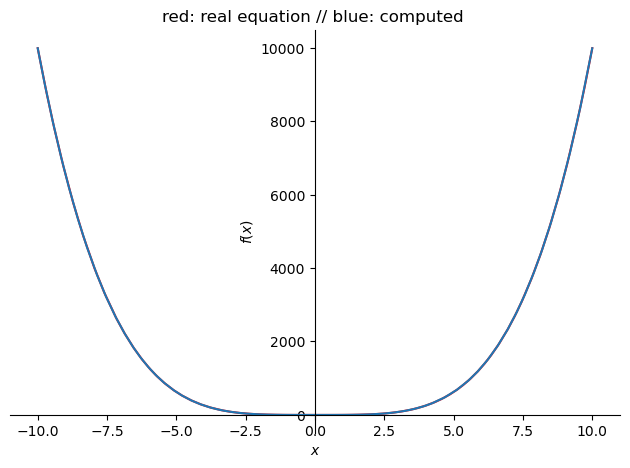

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.5
crossover probability:  0.45

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 5)
Fitness -0.5000899999999789
Index 0



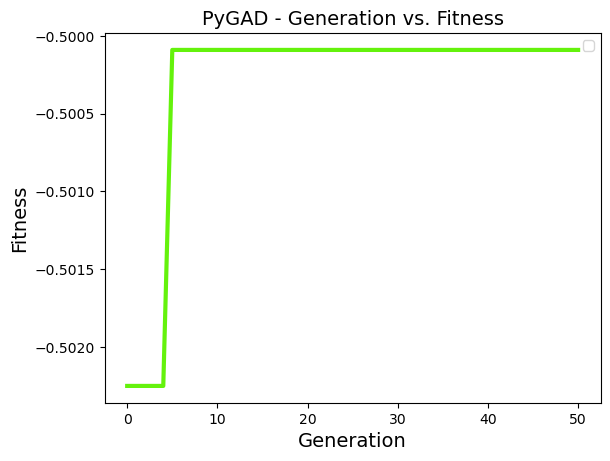

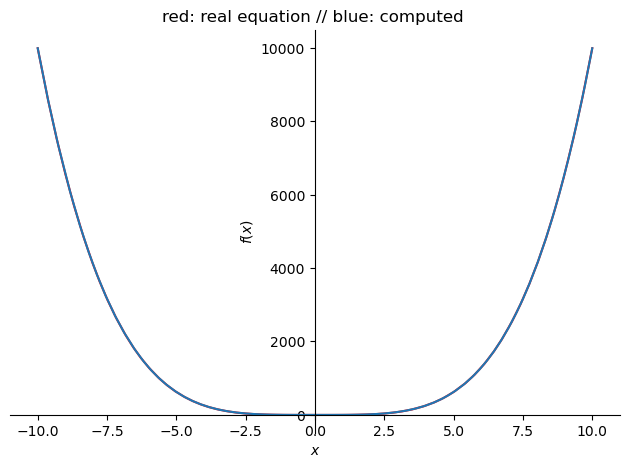

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


result----------
mutation rate:  0.5
crossover probability:  0.8

Real equation:  ((x ** 4) - 6)
Best parameter: ((x ** 4) - 5)
Fitness -0.5000899999999789
Index 0



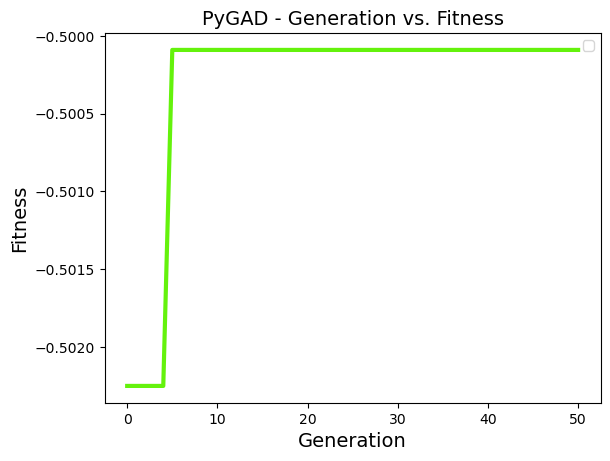

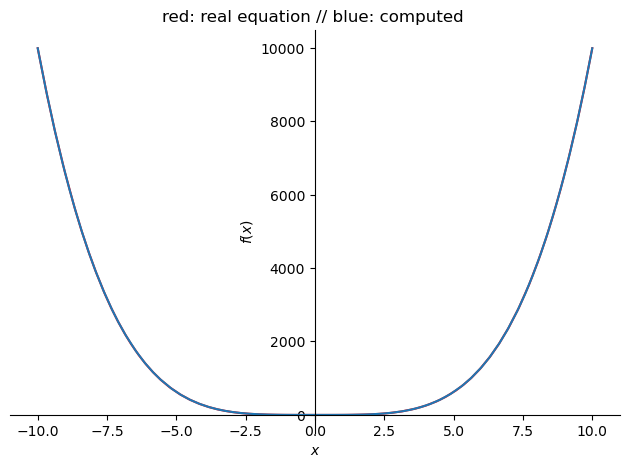

In [556]:
mutation_rates = [0.01, 0.05, 0.1, 0.5]
crossover_probablities = [0.1, 0.45, 0.8]
parent_selections = ['sss','sus','random','tournament']
#MUTATION_PROBABILITY = 0.1
#CROSSOVER_PROBABILITY = 0.8
POPULATION_SIZE_FINAL = 30
MAX_DEPTH_FINAL = 3
NUM_OF_GENES_FINAL = 50
INITIAL_POPULATION = initialize_population(POPULATION_SIZE_FINAL, MAX_DEPTH_FINAL, NUM_OF_GENES_FINAL) 
GENE_SPACE = determine_gene_space(INITIAL_POPULATION)

# uncomment to see the intital population
#for i in INITIAL_POPULATION:
    #print("initial population:", i)
    #print("equation: ",pre_order_to_equation(translate(i)))

result_fitness_values = []

for mutation_rate in mutation_rates:
    for crossover_rate in crossover_probablities:
        # Initialize and run PyGAD with the current mutation rate
        ga_instance = pygad.GA( num_generations=50,
                                mutation_probability = mutation_rate,
                                crossover_probability = crossover_rate,
                                initial_population = INITIAL_POPULATION,
                                num_parents_mating=15,
                                fitness_func= fitness_function,
                                sol_per_pop=20,
                                num_genes=NUM_OF_GENES_FINAL, 
                                mutation_type= custom_mutation_2,
                                crossover_type= crossover_singlepoint,
                                gene_type=int,
                                gene_space=GENE_SPACE,
                                parent_selection_type = "sss"
        )

        ga_instance.run()

        # translate solution into equation to see result
        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        solution = pre_order_to_equation(translate(solution))
        print("result----------")
        print("mutation rate: ",mutation_rate)
        print("crossover probability: ",crossover_rate)
        print("\nReal equation: ", equation)
        #print("shortened real equation: ", simplify(equation))
        print("Best parameter:", solution)
        #print("shortened solution: ", simplify(solution))
        print("Fitness", solution_fitness)
        print("Index", solution_idx)
        print()

        result_fitness_values.append((mutation_rate, crossover_rate, solution_fitness))

        
        #fitness value and generation
        ga_instance.plot_fitness()

        #show real graph and solution graph
        x = sympy.symbols('x')

        p1=plot(equation, solution, show=False)
        p1[0].line_color = 'r'
        p1.title = "red: real equation // blue: computed "
        p1.show()
        
        
result_fitness_values = np.array(result_fitness_values)


[0.01 0.01 0.01 0.05 0.05 0.05 0.1  0.1  0.1  0.5  0.5  0.5 ] mutation probablity
[0.1  0.45 0.8  0.1  0.45 0.8  0.1  0.45 0.8  0.1  0.45 0.8 ] crossover rate
[-0.5     -0.5     -0.50009 -0.50009 -0.5     -0.5     -0.50009 -0.5
 -0.50009 -0.5     -0.50009 -0.50009] fitness


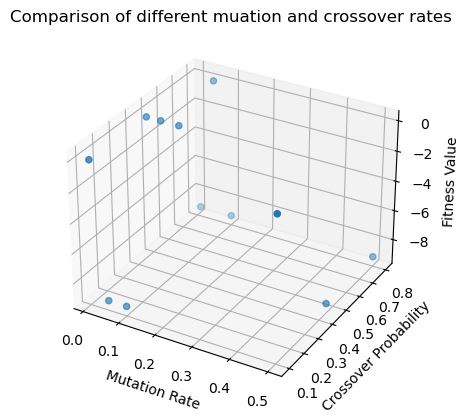

In [557]:
# plot the fitness of different mutation and crossovers rates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result_fitness_values[:, 0], result_fitness_values[:, 1], result_fitness_values[:, 2])
print(result_fitness_values[:, 0], "mutation probablity")
print(result_fitness_values[:, 1], "crossover rate")
print(result_fitness_values[:, 2], "fitness")
ax.set_xlabel('Mutation Rate')
ax.set_ylabel('Crossover Probability')
ax.set_zlabel('Fitness Value')
ax.set_title("Comparison of different muation and crossover rates")
plt.show()